# PyTorch Introduction

Today, we will be intoducing PyTorch, "an open source deep learning platform that provides a seamless path from research prototyping to production deployment".

This notebook is by no means comprehensive. If you have any questions the documentation and Google are your friends.

Goal takeaways:
- Automatic differentiation is a powerful tool
- PyTorch implements common functions used in deep learning

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np

torch.manual_seed(446)
np.random.seed(446)

## Tensors and relation to numpy

By this point, we have worked with numpy quite a bit. PyTorch's basic building block, the `tensor` is similar to numpy's `ndarray`

In [ ]:
# we create tensors in a similar way to numpy nd arrays
x_numpy = np.array([0.1, 0.2, 0.3])
x_torch = torch.tensor([0.1, 0.2, 0.3])
print('x_numpy, x_torch')
print(f"Numpy: {x_numpy}")
print(f"Torch: {x_torch}")
print()

# to and from numpy, pytorch
print('to and from numpy and pytorch')
print(f"Numpy -> Torch: {torch.from_numpy(x_numpy)}")
print(f"Torch -> Numpy: {x_torch.numpy()}")
print()

# we can do basic operations like +-*/
y_numpy = np.array([3,4,5.])
y_torch = torch.tensor([3,4,5.])
print("x+y")
print(f"Numpy: {x_numpy + y_numpy}")
print(f"Torch: {x_torch + y_torch}")
print()

# many functions that are in numpy are also in pytorch
print("norm")
print(f"Numpy: {np.linalg.norm(x_numpy):.6g}")
print(f"Torch: {torch.norm(x_torch):.6g}")
print()

# to apply an operation along a dimension,
# we use the dim keyword argument instead of axis
x_numpy = np.array([[1,2],[3,4.]])
x_torch = torch.tensor([[1,2],[3,4.]])
print("mean along the 0th dimension")
print(f"Numpy: {np.mean(x_numpy, axis=0)}")
print(f"Torch: {torch.mean(x_torch, dim=0)}")


x_numpy, x_torch
Numpy: [0.1 0.2 0.3]
Torch: tensor([0.1000, 0.2000, 0.3000])

to and from numpy and pytorch
Numpy -> Torch: tensor([0.1000, 0.2000, 0.3000], dtype=torch.float64)
Torch -> Numpy: [0.1 0.2 0.3]

x+y
Numpy: [3.1 4.2 5.3]
Torch: tensor([3.1000, 4.2000, 5.3000])

norm
Numpy: 0.374166
Torch: 0.374166

mean along the 0th dimension
Numpy: [2. 3.]
Torch: tensor([2., 3.])


### `Tensor.view`
We can use the `Tensor.view()` function to reshape tensors similarly to `numpy.reshape()`.

**Note:** A imporant difference between `view` and `reshape` is that `view` returns reference to the same tensor as the one passed in. This means that if we modify values in the output of `view` they will also change for its input. This can lead to some issues. For more information see [PyTorch](https://pytorch.org/docs/stable/tensor_view.html).

Similarly to `reshape` it can also automatically calculate the correct dimension if a `-1` is passed in. This is useful if we are working with batches, but the batch size is unknown.

In [ ]:
# "MNIST" - like
N, C, W, H = 10000, 3, 28, 28
X = torch.randn((N, C, W, H))

print(X.shape)
print(X.view(N, C, 784).shape)
print(X.view(-1, C, 784).shape) # automatically choose the 0th dimension

# Alternatively you can use torch.reshape, though it's less commonly used
print(torch.reshape(X, (-1, C, 784)).shape)

torch.Size([10000, 3, 28, 28])
torch.Size([10000, 3, 784])
torch.Size([10000, 3, 784])
torch.Size([10000, 3, 784])


## PyTorch as an auto grad framework

Main benefit of PyTorch is that it keeps track of gradients for us, as we do the calculations.
This is done through computation graphs, which you can read more about in Appendix 1 of this notebook.
The example below shows how to use these gradients.

Consider the function $f(x) = (x-2)^2$.

Q: Compute $\frac{d}{dx} f(x)$ and then compute $f'(1)$.

We make a `backward()` call on the leaf variable (`y`) in the computation, computing all the gradients of `y` at once.

In [ ]:
def f(x):
    return (x-2)**2

def fp(x):
    return 2*(x-2)

x = torch.tensor([1.0], requires_grad=True)

y = f(x)
y.backward()

print('Analytical f\'(x):', fp(x))
print('PyTorch\'s f\'(x):', x.grad)


Analytical f'(x): tensor([-2.], grad_fn=<MulBackward0>)
PyTorch's f'(x): tensor([-2.])


It can also find gradients of functions.

Let $w = [w_1, w_2]^T$

Consider $g(w) = 2w_1w_2 + w_2\cos(w_1)$

Q: Compute $\nabla_w g(w)$ and verify $\nabla_w g([\pi,1]) = [2, \pi - 1]^T$

In [ ]:
def g(w):
    return 2*w[0]*w[1] + w[1]*torch.cos(w[0])

def grad_g(w):
    return torch.tensor([2*w[1] - w[1]*torch.sin(w[0]), 2*w[0] + torch.cos(w[0])])

w = torch.tensor([np.pi, 1], requires_grad=True)

z = g(w)
z.backward()

print('Analytical grad g(w)', grad_g(w))
print('PyTorch\'s grad g(w)', w.grad)

Analytical grad g(w) tensor([2.0000, 5.2832])
PyTorch's grad g(w) tensor([2.0000, 5.2832])


## Using the gradients - Linear regression using GD with torch
Now that we have gradients, we can use our favorite optimization algorithm: gradient descent!

**Note**: This example is an illustration to connect ideas we have seen before to PyTorch's way of doing things. We will see how to do this in the "PyTorchic" way in the next example.

But first lets generate synthetic data to solve on our problem.

In [ ]:
# make a simple linear dataset with some noise
d = 2
n = 50

X = torch.randn(n,d)
true_w = torch.tensor([[-1.0], [2.0]])
y = X @ true_w + torch.randn(n,1) * 0.1
print('X shape', X.shape)
print('y shape', y.shape)
print('w shape', true_w.shape)


X shape torch.Size([50, 2])
y shape torch.Size([50, 1])
w shape torch.Size([2, 1])


We will also define a helper function to visualize result's of what $\hat{w}$ we have learned.

In [ ]:
def visualize_fun(w, title, num_pts=20):
    
    x1, x2 = np.meshgrid(np.linspace(-2,2, num_pts), np.linspace(-2,2, num_pts))
    X_plane = torch.tensor(np.stack([np.reshape(x1, (num_pts**2)), np.reshape(x2, (num_pts**2))], axis=1)).float()
    y_plane = np.reshape((X_plane @ w).detach().numpy(), (num_pts, num_pts))
    
    plt3d = plt.figure().gca(projection='3d')
    plt3d.plot_surface(x1, x2, y_plane, alpha=0.2)

    ax = plt.gca()
    ax.scatter(X[:,0].numpy(), X[:,1].numpy(), y.numpy(), c='r', marker='o')

    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    ax.set_zlabel('$Y$')
    
    plt.title(title)
    plt.show()

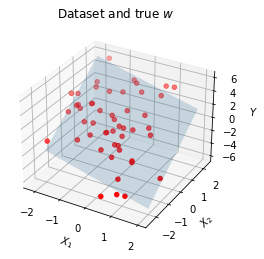

In [ ]:
visualize_fun(true_w, 'Dataset and true $w$')

### Algorithm for Linear regression using GD with automatically computed derivatives

**Note**: This example is an illustration to connect ideas we have seen before to PyTorch's way of doing things. We will see how to do this in the "PyTorchic" way in the next example.

In [ ]:
# define a linear model with no bias
def model(X, w):
    return X @ w

# the residual sum of squares loss function
def rss(y, y_hat):
    return torch.norm(y - y_hat)**2 / n

# Define hyperparameters
step_size = 0.1

# And starting w
w = torch.tensor([[1.], [0]], requires_grad=True)

print('iter,\tloss,\tw')
for i in range(20):
    y_hat = model(X, w)
    loss = rss(y, y_hat)
    
    loss.backward() # compute the gradient of the loss
    
    w.data = w.data - step_size * w.grad # do a gradient descent step
    
    print('{},\t{:.2f},\t{}'.format(i, loss.item(), w.view(2).detach().numpy()))
    
    # We need to zero the grad variable since the backward()
    # call accumulates the gradients in .grad instead of overwriting.
    # The detach_() is for efficiency. You do not need to worry too much about it.
    w.grad.detach()
    w.grad.zero_()

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', w.view(2).detach().numpy())

iter,	loss,	w
0,	10.80,	[0.4813288 0.5591256]
1,	5.77,	[0.09721348 0.96224976]
2,	3.09,	[-0.18760675  1.2525702 ]
3,	1.66,	[-0.39907765  1.4613875 ]
4,	0.89,	[-0.55630636  1.6113691 ]
5,	0.48,	[-0.6733763  1.7189198]
6,	0.26,	[-0.76067793  1.7959039 ]
7,	0.15,	[-0.8258846  1.8508956]
8,	0.08,	[-0.8746693  1.8900856]
9,	0.05,	[-0.9112309  1.9179397]
10,	0.03,	[-0.93868095  1.9376758 ]
11,	0.02,	[-0.95932806  1.9516102 ]
12,	0.02,	[-0.97488767  1.9614073 ]
13,	0.01,	[-0.98663604  1.968262  ]
14,	0.01,	[-0.9955243  1.97303  ]
15,	0.01,	[-1.0022622  1.9763234]
16,	0.01,	[-1.0073804  1.9785789]
17,	0.01,	[-1.0112761  1.9801074]
18,	0.01,	[-1.0142475  1.9811295]
19,	0.01,	[-1.0165185  1.981801 ]

true w		 [-1.  2.]
estimated w	 [-1.0165185  1.981801 ]


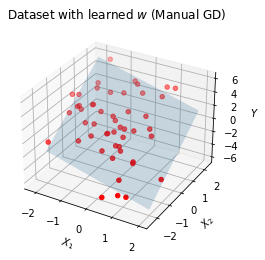

In [ ]:
visualize_fun(w, 'Dataset with learned $w$ (Manual GD)')

## torch.nn.Module

`Module` is PyTorch's way of performing operations on tensors. Modules are implemented as subclasses of the `torch.nn.Module` class. All modules are callable and can be composed together to create complex functions.

[`torch.nn` docs](https://pytorch.org/docs/stable/nn.html)

Note: most of the functionality implemented for modules can be accessed in a functional form via `torch.nn.functional`, but these require you to create and manage the weight tensors yourself. **Note:** This

[`torch.nn.functional` docs](https://pytorch.org/docs/stable/nn.html#torch-nn-functional).

### Linear Module
The bread and butter of modules is the Linear module which does a linear transformation with a bias. It takes the input and output dimensions as parameters, and creates the weights in the object. It is just a matrix multiplication and addition of bias:

$$ f(X) = XW + b, f: \mathbb{R}^{n \times d} \rightarrow \mathbb{R}^{n \times h} $$

where $X \in \mathbb{R}^{n \times d}$, $W \in \mathbb{R}^{d \times h}$ and $b \in \mathbb{R}^{h}$

Unlike how we initialized our $w$ manually, the Linear module automatically initializes the weights randomly. For minimizing non convex loss functions (e.g. training neural networks), initialization is important and can affect results. If training isn't working as well as expected, one thing to try is manually initializing the weights to something different from the default. PyTorch implements some common initializations in `torch.nn.init`.

[`torch.nn.init` docs](https://pytorch.org/docs/stable/nn.html#torch-nn-init)

In [ ]:
d_in = 3
d_out = 4
linear_module = nn.Linear(d_in, d_out)

example_tensor = torch.tensor([[1.,2,3], [4,5,6]])
# applys a linear transformation to the data
transformed = linear_module(example_tensor)
print('example_tensor', example_tensor.shape)
print('transformed', transformed.shape)
print()
print('We can see that the weights exist in the background\n')
print('W:', linear_module.weight)
print('b:', linear_module.bias)

example_tensor torch.Size([2, 3])
transformed torch.Size([2, 4])

We can see that the weights exist in the background

W: Parameter containing:
tensor([[ 0.2151, -0.2631,  0.4498],
        [-0.3092,  0.3098, -0.4239],
        [-0.0499, -0.2222,  0.0085],
        [-0.0356,  0.5260,  0.4925]], requires_grad=True)
b: Parameter containing:
tensor([-0.0887,  0.3944,  0.4080,  0.2182], requires_grad=True)


### Activation functions
PyTorch implements a number of activation functions including but not limited to `ReLU`, `Tanh`, and `Sigmoid`. Since they are modules, they need to be instantiated.

In [ ]:
activation_fn = nn.ReLU() # we instantiate an instance of the ReLU module
example_tensor = torch.tensor([-1.0, 1.0, 0.0])
activated = activation_fn(example_tensor)
print('example_tensor', example_tensor)
print('activated', activated)

example_tensor tensor([-1.,  1.,  0.])
activated tensor([0., 1., 0.])


### Sequential

Many times, we want to compose Modules together. `torch.nn.Sequential` provides a good interface for composing simple modules.

In [ ]:
d_in = 3
d_hidden = 4
d_out = 1
model = torch.nn.Sequential(
    nn.Linear(d_in, d_hidden),
    nn.Tanh(),
    nn.Linear(d_hidden, d_out),
    nn.Sigmoid()
)

example_tensor = torch.tensor([[1.,2,3],[4,5,6]])
transformed = model(example_tensor)
print('transformed', transformed.shape)

transformed torch.Size([2, 1])


Note: we can access *all* of the parameters (of any `nn.Module`) with the `parameters()` method. 

In [ ]:
params = model.parameters()

for param in params:
    print(param)

Parameter containing:
tensor([[-0.1409,  0.0518,  0.3034],
        [ 0.0913,  0.2452, -0.2616],
        [ 0.5021,  0.0118,  0.1383],
        [ 0.4757, -0.3128,  0.2707]], requires_grad=True)
Parameter containing:
tensor([-0.3952,  0.1285,  0.1777, -0.4675], requires_grad=True)
Parameter containing:
tensor([[ 0.0391, -0.4876, -0.1731,  0.4704]], requires_grad=True)
Parameter containing:
tensor([0.0454], requires_grad=True)


### Loss functions
PyTorch implements many common loss functions including `MSELoss` and `CrossEntropyLoss`.

In [ ]:
mse_loss_fn = nn.MSELoss()

input = torch.tensor([[0., 0, 0]])
target = torch.tensor([[1., 0, -1]])

loss = mse_loss_fn(input, target)

print(loss)

tensor(0.6667)


## torch.optim
PyTorch implements a number of gradient-based optimization methods in `torch.optim`, including Gradient Descent. At the minimum, it takes in the model parameters and a learning rate.

Optimizers do not compute the gradients for you, so you must call `backward()` yourself. You also must call the `optim.zero_grad()` function before calling `backward()` since by default PyTorch does and inplace add to the `.grad` member variable rather than overwriting it.

This does both the `detach_()` and `zero_()` calls on all tensor's `grad` variables.

[`torch.optim` docs](https://pytorch.org/docs/stable/optim.html)

In [ ]:
# create a simple model
model = nn.Linear(1, 1)

# create a simple dataset
X_simple = torch.tensor([[1.]])
y_simple = torch.tensor([[2.]])

# create our optimizer
optim = torch.optim.SGD(model.parameters(), lr=1e-2)
mse_loss_fn = nn.MSELoss()

y_hat = model(X_simple)
print('model params before:', model.weight)
loss = mse_loss_fn(y_hat, y_simple)
optim.zero_grad()
loss.backward()
optim.step()
print('model params after:', model.weight)


model params before: Parameter containing:
tensor([[0.1950]], requires_grad=True)
model params after: Parameter containing:
tensor([[0.2219]], requires_grad=True)


As we can see, the parameter was updated in the correct direction

## Linear regression using GD with torch.nn module

Now let's combine what we've learned to solve linear regression in a "PyTorchic" way.

In [ ]:
step_size = 0.1

linear_module = nn.Linear(d, 1, bias=False)

loss_func = nn.MSELoss()

optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)

print('iter,\tloss,\tw')

for i in range(20):
    y_hat = linear_module(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(2).detach().numpy()))

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', linear_module.weight.view(2).detach().numpy())

iter,	loss,	w
0,	4.37,	[-0.5072827  0.7721884]
1,	2.34,	[-0.6624694  1.0903175]
2,	1.25,	[-0.77252483  1.3242052 ]
3,	0.67,	[-0.85030663  1.4962891 ]
4,	0.36,	[-0.90505993  1.6230037 ]
5,	0.20,	[-0.9434225  1.716392 ]
6,	0.11,	[-0.9701522  1.7852831]
7,	0.06,	[-0.98865306  1.8361537 ]
8,	0.04,	[-1.0013554  1.8737577]
9,	0.02,	[-1.0099901  1.9015862]
10,	0.02,	[-1.0157865  1.9222052]
11,	0.01,	[-1.019615   1.9375019]
12,	0.01,	[-1.0220896  1.9488654]
13,	0.01,	[-1.0236413  1.9573189]
14,	0.01,	[-1.0245715  1.963617 ]
15,	0.01,	[-1.0250894  1.9683164]
16,	0.01,	[-1.0253391  1.9718288]
17,	0.01,	[-1.0254192  1.9744583]
18,	0.01,	[-1.0253965  1.9764304]
19,	0.01,	[-1.025315   1.9779121]

true w		 [-1.  2.]
estimated w	 [-1.025315   1.9779121]


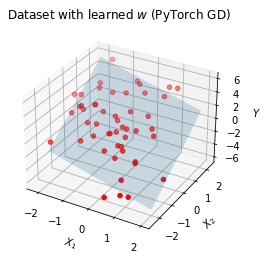

In [ ]:
visualize_fun(linear_module.weight.t(), 'Dataset with learned $w$ (PyTorch GD)')

## Linear regression using SGD 
In the previous examples, we computed the average gradient over the entire dataset (Gradient Descent). We can implement Stochastic Gradient Descent with a simple modification.

In [ ]:
step_size = 0.01

linear_module = nn.Linear(d, 1)
loss_func = nn.MSELoss()
optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)
print('iter,\tloss,\tw')
for i in range(200):
    rand_idx = np.random.choice(n) # take a random point from the dataset
    x = X[rand_idx] 
    y_hat = linear_module(x)
    loss = loss_func(y_hat, y[rand_idx]) # only compute the loss on the single point
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % 20 == 0:
        print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(2).detach().numpy()))

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', linear_module.weight.view(2).detach().numpy())

iter,	loss,	w
0,	0.01,	[-0.16747227  0.69458336]
20,	0.73,	[-0.5277779  1.409119 ]
40,	0.05,	[-0.7416818  1.7194623]
60,	0.04,	[-0.80749375  1.8314769 ]
80,	0.09,	[-0.888827   1.8813882]
100,	0.06,	[-0.93712914  1.9570426 ]
120,	0.00,	[-0.964763   1.9772898]
140,	0.00,	[-0.9806282  1.9791763]
160,	0.04,	[-0.9831248  1.9838824]
180,	0.01,	[-0.9979536  1.9885796]

true w		 [-1.  2.]
estimated w	 [-0.9991454  1.9860797]


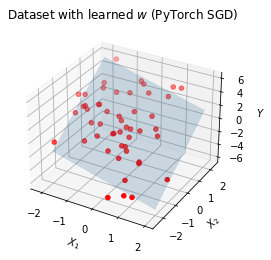

In [ ]:
visualize_fun(linear_module.weight.t(), 'Dataset with learned $w$ (PyTorch SGD)')

# Neural Network Basics in PyTorch

Let's consider the dataset from hw3. We will try and fit a simple neural network to the data.

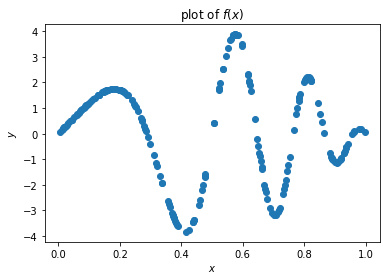

In [ ]:
%matplotlib inline

d = 1
n = 200
X = torch.rand(n,d)
y = 4 * torch.sin(np.pi * X) * torch.cos(6*np.pi*X**2)

plt.scatter(X.numpy(), y.numpy())
plt.title('plot of $f(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

Here we define a simple two hidden layer neural network with Tanh activations. There are a few hyper parameters to play with to get a feel for how they change the results.

In [ ]:
# feel free to play with these parameters

step_size = 0.05
n_epochs = 6000
n_hidden_1 = 32
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
                            nn.Linear(d, n_hidden_1), 
                            nn.Tanh(),
                            nn.Linear(n_hidden_1, n_hidden_2),
                            nn.Tanh(),
                            nn.Linear(n_hidden_2, d_out)
                            )

loss_func = nn.MSELoss()

optim = torch.optim.SGD(neural_network.parameters(), lr=step_size)
print('iter,\tloss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        print('{},\t{:.2f}'.format(i, loss.item()))



iter,	loss
0,	3.96
600,	3.69
1200,	2.58
1800,	1.10
2400,	0.91
3000,	0.68
3600,	0.14
4200,	0.08
4800,	0.06
5400,	0.15


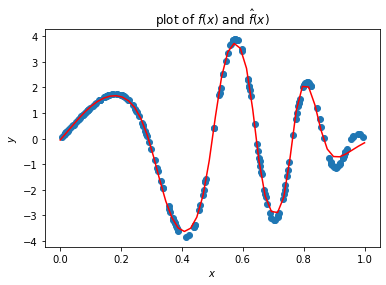

In [ ]:
X_grid = torch.from_numpy(np.linspace(0,1,50)).float().view(-1, d)
y_hat = neural_network(X_grid)
plt.scatter(X.numpy(), y.numpy())
plt.plot(X_grid.detach().numpy(), y_hat.detach().numpy(), 'r')
plt.title('plot of $f(x)$ and $\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

## Useful links:
- [60 minute PyTorch Tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
- [PyTorch Docs](https://pytorch.org/docs/stable/index.html)
- [Lecture notes on Auto-Diff](https://courses.cs.washington.edu/courses/cse446/19wi/notes/auto-diff.pdf)



# Appendix 1:  Computation graphs

What's special about PyTorch's `tensor` object is that it implicitly creates a computation graph in the background. A computation graph is a a way of writing a mathematical expression as a graph. There is an algorithm to compute the gradients of all the variables of a computation graph in time on the same order it is to compute the function itself.

Consider the expression $e=(a+b)*(b+1)$ with values $a=2, b=1$. We can draw the evaluated computation graph as
<br>
<br>

<img src="https://colah.github.io/posts/2015-08-Backprop/img/tree-eval-derivs.png" />

[source](https://colah.github.io/posts/2015-08-Backprop/)

In PyTorch, we can write this as

In [ ]:
a = torch.tensor(2.0, requires_grad=True) # we set requires_grad=True to let PyTorch know to keep the graph
b = torch.tensor(1.0, requires_grad=True)
c = a + b
d = b + 1
e = c * d
print('c', c)
print('d', d)
print('e', e)

c tensor(3., grad_fn=<AddBackward0>)
d tensor(2., grad_fn=<AddBackward0>)
e tensor(6., grad_fn=<MulBackward0>)


We can see that PyTorch kept track of the computation graph for us.

# Appendix 2: Things that might help on the homework

## Momentum

There are other optimization algorithms besides stochastic gradient descent. One is a modification of SGD called momentum. We won't get into it here, but if you would like to read more [here](https://distill.pub/2017/momentum/) is a good place to start.

We only change the step size and add the momentum keyword argument to the optimizer. Notice how it reduces the training loss in fewer iterations.

In [ ]:
# feel free to play with these parameters

step_size = 0.05
momentum = 0.9
n_epochs = 1500
d = X.shape[1]
n_hidden_1 = 32
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
    nn.Linear(d, n_hidden_1), 
    nn.Tanh(),
    nn.Linear(n_hidden_1, n_hidden_2),
    nn.Tanh(),
    nn.Linear(n_hidden_2, d_out)
)

loss_func = nn.MSELoss()

optim = torch.optim.SGD(neural_network.parameters(), lr=step_size, momentum=momentum)
print('iter,\tloss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        print('{},\t{:.2f}'.format(i, loss.item()))



iter,	loss
0,	3.83
150,	3.06
300,	0.74
450,	0.12
600,	0.04
750,	0.03
900,	0.01
1050,	0.00
1200,	0.00
1350,	0.00


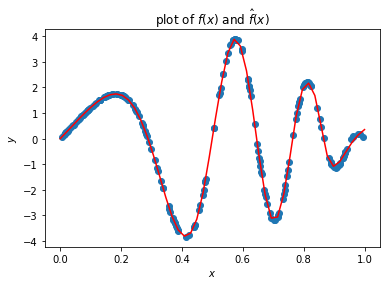

In [ ]:
X_grid = torch.from_numpy(np.linspace(0,1,50)).float().view(-1, d)
y_hat = neural_network(X_grid)
plt.scatter(X.numpy(), y.numpy())
plt.plot(X_grid.detach().numpy(), y_hat.detach().numpy(), 'r')
plt.title('plot of $f(x)$ and $\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

## CrossEntropyLoss
So far, we have been considering regression tasks and have used the [MSELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.MSELoss) module. For the homework, we will be performing a classification task and will use the cross entropy loss.

PyTorch implements a version of the cross entropy loss in one module called [CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss). Its usage is slightly different than MSE, so we will break it down here. 

- input: The first parameter to CrossEntropyLoss is the output of our network. It expects a *real valued* tensor of dimensions $(N,C)$ where $N$ is the minibatch size and $C$ is the number of classes. In our case $N=3$ and $C=2$. The values along the second dimension correspond to raw unnormalized scores for each class. The CrossEntropyLoss module does the softmax calculation for us, so we do not need to apply our own softmax to the output of our neural network.
- output: The second parameter to CrossEntropyLoss is the true label. It expects an *integer valued* tensor of dimension $(N)$. The integer at each element corresponds to the correct class. In our case, the "correct" class labels are class 0, class 1, and class 1.

Try out the loss function on three toy predictions. The true class labels are $y=[1,1,0]$. The first two examples correspond to predictions that are "correct" in that they have higher raw scores for the correct class. The second example is "more confident" in the prediction, leading to a smaller loss. The last two examples are incorrect predictions with lower and higher confidence respectively.

In [ ]:
loss = nn.CrossEntropyLoss()

input = torch.tensor([[-1., 1],[-1, 1],[1, -1]]) # raw scores correspond to the correct class
# input = torch.tensor([[-3., 3],[-3, 3],[3, -3]]) # raw scores correspond to the correct class with higher confidence
# input = torch.tensor([[1., -1],[1, -1],[-1, 1]]) # raw scores correspond to the incorrect class
# input = torch.tensor([[3., -3],[3, -3],[-3, 3]]) # raw scores correspond to the incorrect class with incorrectly placed confidence

target = torch.tensor([1, 1, 0])
output = loss(input, target)
print(output)


tensor(0.1269)


## Learning rate schedulers

Often we do not want to use a fixed learning rate throughout all training. PyTorch offers learning rate schedulers to change the learning rate over time. Common strategies include multiplying the lr by a constant every epoch (e.g. 0.9) and halving the learning rate when the training loss flattens out.

See the [learning rate scheduler docs](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for usage and examples

# Appendix 3: Beyond Linear Layers

## Convolutions
When working with images, we often want to use convolutions to extract features using convolutions. PyTorch implments this for us in the `torch.nn.Conv2d` module. It expects the input to have a specific dimension $(N, C_{in}, H_{in}, W_{in})$ where $N$ is batch size, $C_{in}$ is the number of channels the image has, and $H_{in}, W_{in}$ are the image height and width respectively.

We can modify the convolution to have different properties with the parameters:
- kernel_size
- stride
- padding

They can change the output dimension so be careful.

See the [`torch.nn.Conv2d` docs](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) for more information.

To illustrate what the `Conv2d` module is doing, let's set the conv weights manually to a Gaussian blur kernel.

We can see that it applies the kernel to the image.

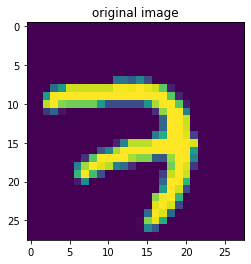

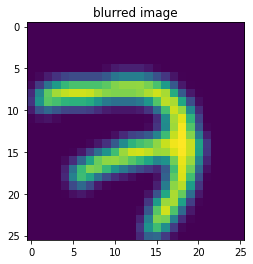

In [ ]:
# an entire mnist digit
image = np.array([0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.3803922 , 0.37647063, 0.3019608 ,0.46274513, 0.2392157 , 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.3529412 , 0.5411765 , 0.9215687 ,0.9215687 , 0.9215687 , 0.9215687 , 0.9215687 , 0.9215687 ,0.9843138 , 0.9843138 , 0.9725491 , 0.9960785 , 0.9607844 ,0.9215687 , 0.74509805, 0.08235294, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.54901963,0.9843138 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.7411765 , 0.09019608, 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.8862746 , 0.9960785 , 0.81568635,0.7803922 , 0.7803922 , 0.7803922 , 0.7803922 , 0.54509807,0.2392157 , 0.2392157 , 0.2392157 , 0.2392157 , 0.2392157 ,0.5019608 , 0.8705883 , 0.9960785 , 0.9960785 , 0.7411765 ,0.08235294, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.14901961, 0.32156864, 0.0509804 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.13333334,0.8352942 , 0.9960785 , 0.9960785 , 0.45098042, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.32941177, 0.9960785 ,0.9960785 , 0.9176471 , 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.32941177, 0.9960785 , 0.9960785 , 0.9176471 ,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.4156863 , 0.6156863 ,0.9960785 , 0.9960785 , 0.95294124, 0.20000002, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.09803922, 0.45882356, 0.8941177 , 0.8941177 ,0.8941177 , 0.9921569 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.94117653, 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.26666668, 0.4666667 , 0.86274517,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.5568628 ,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.14509805, 0.73333335,0.9921569 , 0.9960785 , 0.9960785 , 0.9960785 , 0.8745099 ,0.8078432 , 0.8078432 , 0.29411766, 0.26666668, 0.8431373 ,0.9960785 , 0.9960785 , 0.45882356, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.4431373 , 0.8588236 , 0.9960785 , 0.9490197 , 0.89019614,0.45098042, 0.34901962, 0.12156864, 0., 0.,0., 0., 0.7843138 , 0.9960785 , 0.9450981 ,0.16078432, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.6627451 , 0.9960785 ,0.6901961 , 0.24313727, 0., 0., 0.,0., 0., 0., 0., 0.18823531,0.9058824 , 0.9960785 , 0.9176471 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.07058824, 0.48627454, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.32941177, 0.9960785 , 0.9960785 ,0.6509804 , 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.54509807, 0.9960785 , 0.9333334 , 0.22352943, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.8235295 , 0.9803922 , 0.9960785 ,0.65882355, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.9490197 , 0.9960785 , 0.93725497, 0.22352943, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.34901962, 0.9843138 , 0.9450981 ,0.3372549 , 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.01960784,0.8078432 , 0.96470594, 0.6156863 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.01568628, 0.45882356, 0.27058825,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.], dtype=np.float32)
image_torch = torch.from_numpy(image).view(1, 1, 28, 28)

# a gaussian blur kernel
gaussian_kernel = torch.tensor([[1., 2, 1],[2, 4, 2],[1, 2, 1]]) / 16.0

conv = nn.Conv2d(1, 1, 3)
# manually set the conv weight
conv.weight.data[:] = gaussian_kernel

convolved = conv(image_torch)

plt.title('original image')
plt.imshow(image_torch.view(28,28).detach().numpy())
plt.show()

plt.title('blurred image')
plt.imshow(convolved.view(26,26).detach().numpy())
plt.show()

As we can see, the image is blurred as expected. 

In practice, we learn many kernels at a time. In this example, we take in an RGB image (3 channels) and output a 16 channel image. After an activation function, that could be used as input to another `Conv2d` module.

In [ ]:
im_channels = 3 # if we are working with RGB images, there are 3 input channels, with black and white, 1
out_channels = 16 # this is a hyperparameter we can tune
kernel_size = 3 # this is another hyperparameter we can tune
batch_size = 4
image_width = 32
image_height = 32

im = torch.randn(batch_size, im_channels, image_width, image_height)

m = nn.Conv2d(im_channels, out_channels, kernel_size)
convolved = m(im) # it is a module so we can call it

print('im shape', im.shape)
print('convolved im shape', convolved.shape)

im shape torch.Size([4, 3, 32, 32])
convolved im shape torch.Size([4, 16, 30, 30])


## Recurrent Cells (or Recurrent Neural Networks)

In [ ]:
def process_corpus(corpus, sentence_length):
    """
    Arguments:
        corpus (str) -- Continous text. Can be anything but should be relatively long.
        sentence_length (int) -- Size of each sentence in the output.
            Does not have to be divisible by # of words in corpus, in which case end will be padded.
    Returns:
        Tuple of size 4 containing:
            - Train Input - shape (batch, sentence) containing indexes of words for each sentence.
            - Train Truth - Same as Train Input but contains index of the next word in a given sentence.
            - Word to Index Dictionary - Dictionary for each word containing a corresponding integer.
            - Index to Word Dictionary - Reverse of Word to Index Dictionary.
            
    Example:
        process_corpus("Sam likes cats", 2) outputs:
            - [[1, 2], [3, 0]]
            - [[2, 3], [0, 0]]
            - {"": 0, "Sam": 1, "likes": 2, "cats": 3}
            - {0: "", 1: "Sam", 2: "likes", 3: "cats"}
    """
    # Let's make corpus a list of words
    corpus = corpus.split()
    # QUESTION: Should we also trim/lowercase the words here? Is "You," vs. "you" very different?

    # Then split it into smaller sentences of size sentence_length
    x = []
    y = []
    for idx in range(0, len(corpus), sentence_length):
        x.append(corpus[idx: idx + sentence_length])
        # Since we are trying to predict the next word y's are just x's shifted by one
        y.append(corpus[idx + 1: idx + sentence_length + 1])
    # Last sentences might be shorter. Let's pad it with something smaller
    x[-1] += ["" for _ in range(sentence_length - len(x[-1]))]
    y[-1] += ["" for _ in range(sentence_length - len(y[-1]))]

    # Create dictionary from words to indices and vice-versa
    # QUESTION: Is "" a good choice for end-of-sentence tag? Maybe we should pad beginning of the sentences too?
    idx_to_word = {0: ""}
    word_to_idx = {"": 0}
    idx = 1
    for sentence in x:
        for word in sentence:
            if word not in word_to_idx:
                word_to_idx[word] = idx
                idx_to_word[idx] = word
                idx += 1

    x_idx = torch.tensor([[word_to_idx[w] for w in s] for s in x]).long()
    y_idx = torch.tensor([[word_to_idx[w] for w in s] for s in y]).long()

    return x_idx, y_idx, word_to_idx, idx_to_word

In [ ]:
# Feel free to play with parameters
embedding_size = 10
sentence_length = 5
hidden_size = 5
n_epochs = 1000

# Dataset
corpus = "Hey, you. You’re finally awake. " \
    "You were trying to cross the border, right? " \
    "Walked right into that Imperial ambush, " \
    "same as us, and that thief over there. " \
    "Skyrim was fine until you came along. " \
    "Empire was nice and lazy. " \
    "If they hadn’t been looking for you, " \
    "I could’ve stolen that horse and been half way to Hammerfell. " \
    "You there. You and me — we should be here. " \
    "It’s these Stormcloaks the Empire wants. "

x, y, word_to_idx, idx_to_word = process_corpus(corpus, sentence_length)

model_rnn = nn.Sequential(
    nn.Embedding(len(idx_to_word), embedding_size),
    nn.RNN(embedding_size, hidden_size, batch_first=True),
)
# Linear model has to be separate, because we'll be using only first output of the RNN
linear = nn.Linear(hidden_size, len(idx_to_word))
print(model_rnn)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model_rnn.parameters()) + list(linear.parameters()))

for i in range(n_epochs):
    x_mid, _ = model_rnn(x)
    y_hat = linear(x_mid).transpose(1, 2)  # This makes shape correct for the Loss
    loss = criterion(y_hat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % (n_epochs // 10) == 0:
        print('{},\t{:.2f}'.format(i, loss.item()))

Sequential(
  (0): Embedding(61, 10)
  (1): RNN(10, 5, batch_first=True)
)
0,	4.21
100,	3.76
200,	3.32
300,	2.91
400,	2.57
500,	2.29
600,	2.06
700,	1.89
800,	1.75
900,	1.62


In [ ]:
# Let's see a prediction for the first sentence
with torch.no_grad():
    y_hat = linear(model_rnn(x)[0])
    y_hat = torch.argmax(y_hat, dim=2)
    sentences_hat = [[idx_to_word[int(w)] for w in s] for s in y_hat]
    sentences_true = [[idx_to_word[int(w)] for w in s] for s in y]

    sentence_idx = 0
    print(f"Truth: {sentences_true[sentence_idx]}")
    print(f"Predict: {sentences_hat[sentence_idx]}")

# Lets have a custom sentence, with a random word starting.
with torch.no_grad():
    word = "horse"
    sentence = f"{word}"
    for _ in range(15):
        word_idx = torch.tensor([word_to_idx[word]]).reshape(1, 1)
        y_hat, _ = model_rnn(word_idx)
        y_hat = linear(y_hat)
        y_hat = torch.argmax(y_hat, dim=2)
        word = idx_to_word[y_hat.reshape(1).item()]
        sentence += f" {word}"
    print(sentence)
    # See how it repeats itself near the end? There are ways of fixing it!

Truth: ['you.', 'You’re', 'finally', 'awake.', 'You']
Predict: ['you.', 'You’re', 'finally', 'right', 'You']
horse and been half way and been half way and been half way and been half


## Useful links:
- [60 minute PyTorch Tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
- [PyTorch Docs](https://pytorch.org/docs/stable/index.html)
- [Lecture notes on Auto-Diff](https://courses.cs.washington.edu/courses/cse446/19wi/notes/auto-diff.pdf)

